# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
Done.


In [0]:
import requests
import json
from fastai.vision import *

In [0]:
!ls data

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```


In my Chrome, the above  `window.open` does not work, so i just copy the urls to clipboard, and paste them to pastebin.

```
copy('');
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
copy(urls);
```




### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [0]:
folder = 'black'
file = 'urls_black.txt'
pastebin = 'https://pastebin.com/raw/2gubHD6R'

In [0]:
folder = 'teddys'
file = 'urls_teddys.txt'
pastebin = 'https://pastebin.com/raw/WyBUj0R5'

In [0]:
folder = 'grizzly'
file = 'urls_grizzly.txt'
pastebin = 'https://pastebin.com/raw/SiSevrvq'


You will need to run this line once per each category.

In [0]:
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [43]:
path.ls()

[PosixPath('data/bears/urls_teddys.txt'),
 PosixPath('data/bears/black'),
 PosixPath('data/bears/grizzly'),
 PosixPath('data/bears/urls_grizzly.txt'),
 PosixPath('data/bears/teddys')]

In [0]:
r = requests.get(pastebin)
urls = json.loads(r.text)
    
with open(path/file, 'w') as f:
    for url in urls:
        f.write(url+'\n')


Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

![uploaded file](https://github.com/glasslion/fastai-course-v3/blob/master/nbs/dl1/images/download_images/upload.png?raw=1)

## Download images

Now you will need to download you images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename and the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [0]:
classes = ['teddys','grizzly','black']

In [45]:
path/file

PosixPath('data/bears/urls_black.txt')

In [46]:
download_images(path/file, dest, max_pics=200)

Error https://www.washingtonpost.com/resizer/vn6pmHdQPxRzwhhFkpSEsmUp9Qc=/534x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/XK6YBT5GSE2LROLN3FO4WRK5JI.jpg HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=4)


In [0]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(".", folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [49]:
data.classes

['black', 'grizzly', 'teddys']

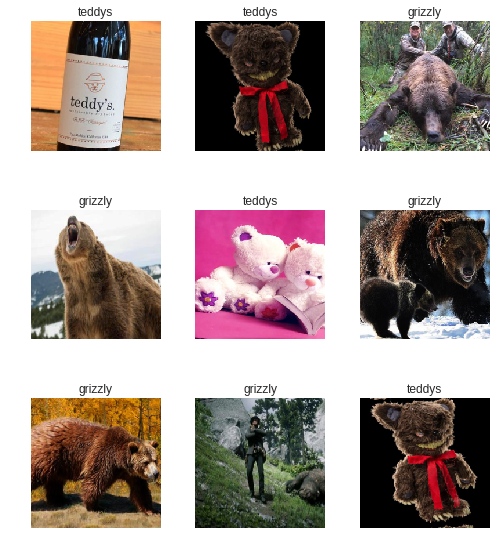

In [50]:
data.show_batch(rows=3, figsize=(7,8))

In [51]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 432, 107)

## Train model

In [52]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 89551680.65it/s]


In [53]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.019424,0.335790,0.084112
2,0.588515,0.263902,0.112150
3,0.427796,0.252175,0.093458
4,0.333592,0.244218,0.084112


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [56]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07


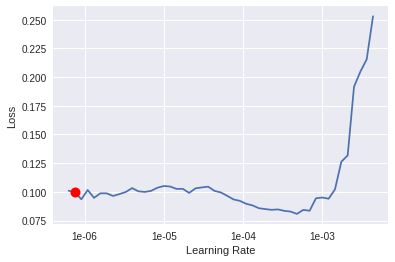

In [57]:
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate
1,0.095763,0.249180,0.084112
2,0.087770,0.266437,0.093458


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

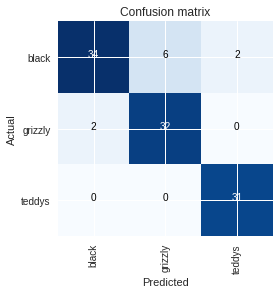

In [62]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [0]:
from fastai.widgets import *

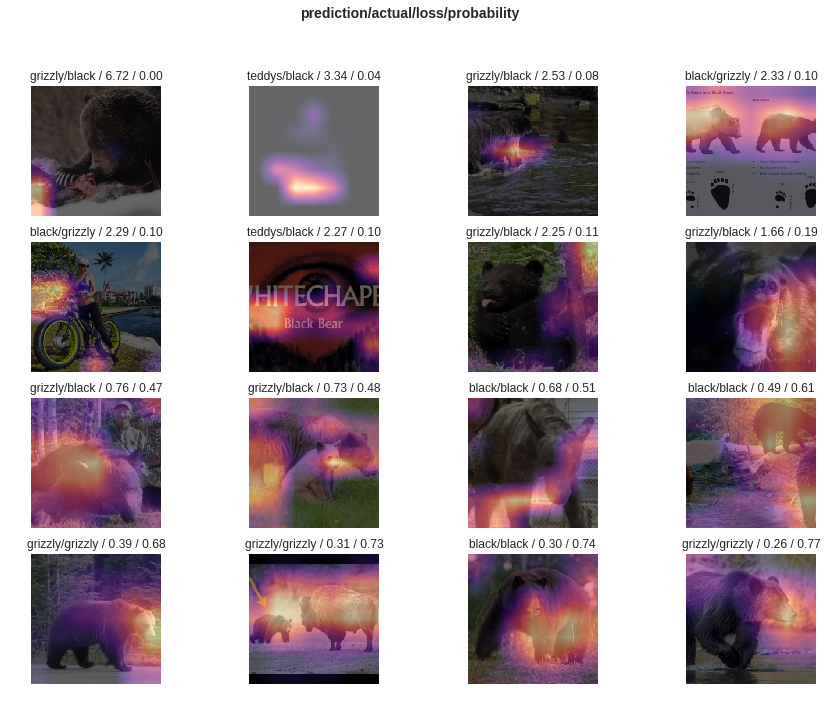

In [64]:
interp.plot_top_losses(16, figsize=(15,11))

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [14]:
ImageCleaner(ds, idxs, path)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

In [0]:
ds, idxs = DatasetFormatter().from_similars(learn, ds_type=DatasetType.Valid)

In [0]:
ImageCleaner(ds, idxs, path, duplicates=True)

'No images to show :)'

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

In [73]:
!ls !ls data/bears/

ls: cannot access '!ls': No such file or directory
data/bears/:
black	    grizzly  teddys	     urls_grizzly.txt
export.pkl  models   urls_black.txt  urls_teddys.txt


This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

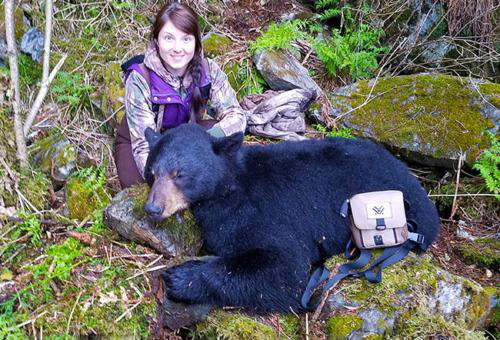

In [69]:
img = open_image(path/'black'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [74]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category black

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [76]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate
1,16.199486,189928112.000000,0.682243


### Learning rate (LR) too low

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [78]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate
1,1.371780,1.342803,0.598131
2,1.321583,1.158246,0.598131
3,1.324310,1.074787,0.551402
4,1.291974,1.031543,0.476636
5,1.282473,1.019984,0.476636


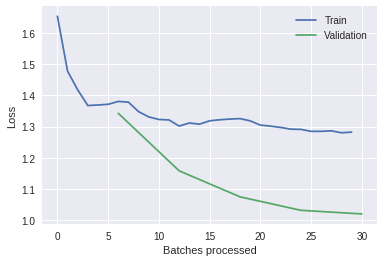

In [80]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [82]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,1.246073,1.139684,0.542056


### Too many epochs

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [84]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 99604116.05it/s]


In [85]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,1.273175,1.320363,0.573196
2,1.259562,1.252859,0.569072
3,1.241181,1.194823,0.562887
4,1.218856,1.135389,0.556701
5,1.168829,1.072800,0.523711
6,1.127564,1.007181,0.498969
7,1.081094,0.933862,0.443299
8,1.042149,0.855575,0.375258
9,0.988200,0.775697,0.296907
10,0.929716,0.700506,0.220619


In [0]:
doc??